## 介绍
将模型在训练数据上拟合的⽐在潜在分布中更接近的现象称为过拟合（overfitting），⽤于对抗过拟合的技术称为正则化（regularization）。在前⾯的章节中，有些读者可能在⽤Fashion-MNIST数据集做实验时已经观察到了这种过拟合现象。在实验中调整模型架构或超参数时会发现：如果有⾜够多的神经元、层数和训练迭代周期，模型最终可以在训练集上达到完美的精度，此时测试集的准确性却下降了。

## 训练误差和泛化误差
* 训练误差（training error）是指，模型在训练数据集上计算得到的误差。
* 泛化误差（generalization error）是指，模型应⽤在同样从原始样本的分布中抽取的⽆限多数据样本时，模型误差的期望。  

在实际中，不能准确地计算出泛化误差。这是因为⽆限多的数据样本是⼀个虚构的对象。只能通过将模型应⽤于⼀个独⽴的测试集来估计泛化误差，该测试集由随机选取的、未曾在训练集中出现的数据样本构成。



### 模型复杂性

当我们有简单的模型和⼤量的数据时，我们期望泛化误差与训练误差相近。当我们有更复杂的模型和更少的样本时，我们预计训练误差会下降，但泛化误差会增⼤。模型复杂性由什么构成是⼀个复杂的问题。⼀个模型是否能很好地泛化取决于很多因素。接下来将重点介绍⼏个倾向于影响模型泛化的因素：  
* 可调整参数的数量。当可调整参数的数量（有时称为⾃由度）很⼤时，模型往往更容易过拟合。
* 参数采⽤的值。当权重的取值范围较⼤时，模型可能更容易过拟合。
* 训练样本的数量。即使模型很简单，也很容易过拟合只包含⼀两个样本的数据集。⽽过拟合⼀个有数百万个样本的数据集则需要⼀个极其灵活的模型。



## 模型选择
通常在评估⼏个候选模型后选择最终的模型，这个过程叫做模型选择。有时，需要进⾏⽐较的模型在本质上是完全不同的（⽐如，决策树与线性模型）。⼜有时，我们需要⽐较不同的超参数设置下的同⼀类模型。  
为了确定候选模型中的最佳模型，通常会使⽤验证集。



### 验证集（Valid）
如果我们在模型选择过程中使⽤测试数据，可能会有过拟合测试数据的⻛险，那就⿇烦⼤了。因此，我们决不能依靠测试数据进⾏模型选择。然⽽，我们也不能仅仅依靠训练数据来选择模型，因为我们⽆法估计训练数据的泛化误差。  
解决此问题的常⻅做法是将我们的数据分成三份，除了训练和测试数据集之外，还增加⼀个验证数据集（validation dataset），也叫验证集（validation set）。


### K折交叉验证（构成验证集的方法）
当训练数据稀缺时，我们甚⾄可能⽆法提供⾜够的数据来构成⼀个合适的验证集。这个问题的⼀个流⾏的解决⽅案是采⽤K折交叉验证。  
原始训练数据被分成K个不重叠的⼦集。然后执⾏K次模型训练和验证，每次在K − 1个⼦集上进⾏训练，并在剩余的⼀个⼦集（在该轮中没有⽤于训练的⼦集）上进⾏验证。最后，通过对K次实验的结果取平均来估计训练和验证误差。

## 欠拟合和过拟合
是否过拟合或⽋拟合可能取决于模型复杂性和可⽤训练数据集的⼤⼩
### 模型复杂性
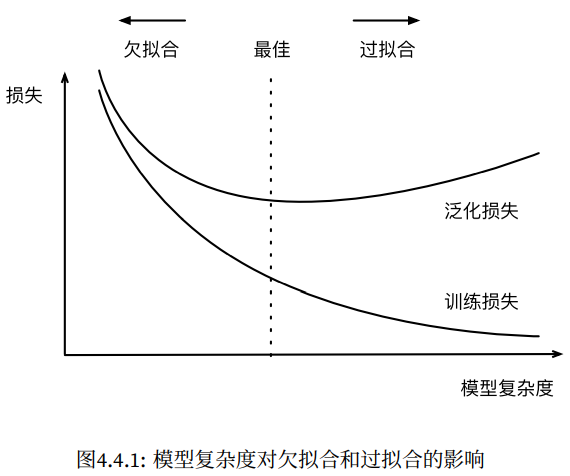

### 数据集大小
训练数据集中的样本越少，我们就越有可能（且更严重地）过拟合。随着训练数据量的增加，泛化误差通常会减⼩。

## 多项式回归


In [1]:
# 通过多项式拟合来探索这些概念
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l


### 生成数据集
给定x，将使⽤以下三阶多项式来⽣成训练和测试数据的标签：  
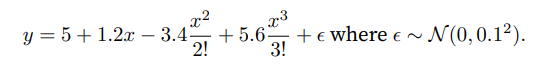  

噪声项ϵ服从均值为0且标准差为0.1的正态分布。在优化的过程中，我们通常希望避免⾮常⼤的梯度值或损失值。这就是我们将特征从xi调整为xi/i! 的原因，这样可以避免很⼤的i带来的特别⼤的指数值。我们将为训练集和测试集各⽣成100个样本。


In [8]:
max_degree = 20 # 多项式的最⼤阶数
n_train, n_test = 100, 100 # 训练和测试数据集⼤⼩
true_w = np.zeros(max_degree) # 分配⼤量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
print('features.shape：',features.shape)
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1) # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)


features.shape： (200, 1)


存储在poly_features中的单项式由gamma函数重新缩放，其中Γ(n) = (n − 1)!。从⽣成的数据集中查看⼀下前2个样本，第⼀个值是与偏置相对应的常量特征。


In [9]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
                                                        torch.float32) for x in [true_w, features, poly_features, labels]]
features[:2], poly_features[:2, :], labels[:2]

(tensor([[1.4230],
         [0.0088]]),
 tensor([[1.0000e+00, 1.4230e+00, 1.0125e+00, 4.8027e-01, 1.7086e-01, 4.8626e-02,
          1.1533e-02, 2.3445e-03, 4.1703e-04, 6.5938e-05, 9.3831e-06, 1.2138e-06,
          1.4394e-07, 1.5756e-08, 1.6016e-09, 1.5194e-10, 1.3513e-11, 1.1311e-12,
          8.9424e-14, 6.6974e-15],
         [1.0000e+00, 8.7661e-03, 3.8423e-05, 1.1227e-07, 2.4605e-10, 4.3138e-13,
          6.3026e-16, 7.8928e-19, 8.6486e-22, 8.4239e-25, 7.3845e-28, 5.8849e-31,
          4.2990e-34, 2.8989e-37, 1.8151e-40, 1.0650e-43, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00]]),
 tensor([5.7994, 4.9593]))

### 对模型进行测试和训练
实现⼀个函数来评估模型在给定数据集上的损失

In [10]:
def evaluate_loss(net, data_iter, loss): #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2) # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [13]:
# 定义训练函数
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

### 三阶多项式函数拟合（正常）
⾸先使⽤三阶多项式函数，它与数据⽣成函数的阶数相同。结果表明，该模型能有效降低训练损失和测试损失。学习到的模型参数也接近真实值w = [5, 1.2, −3.4, 5.6]。

weight: [[ 5.0033135  1.2150036 -3.3907115  5.513494 ]]


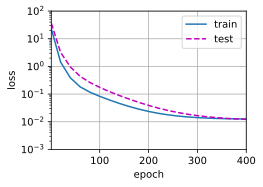

In [14]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

### 线性函数拟合(⽋拟合)
再看看线性函数拟合，减少该模型的训练损失相对困难。在最后⼀个迭代周期完成后，训练损失仍然很⾼。当⽤来拟合⾮线性模式（如这⾥的三阶多项式函数）时，线性模型容易⽋拟合。

weight: [[3.4040842 3.7069783]]


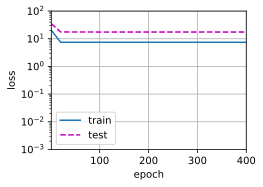

In [15]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])


### ⾼阶多项式函数拟合(过拟合)
尝试使⽤⼀个阶数过⾼的多项式来训练模型。在这种情况下，没有⾜够的数据⽤于学到⾼阶系数应该具有接近于零的值。因此，这个过于复杂的模型会轻易受到训练数据中噪声的影响。虽然训练损失可以有效地降低，但测试损失仍然很⾼。结果表明，复杂模型对数据造成了过拟合。


weight: [[ 4.9681206   1.2748828  -3.2376354   5.1652102  -0.41856173  1.0208769
  -0.06064961  0.14434296  0.06503442 -0.16865441  0.1845012  -0.18232344
   0.04907165 -0.18016323  0.01143863  0.13905263 -0.11441695  0.04288363
   0.04315236  0.05285573]]


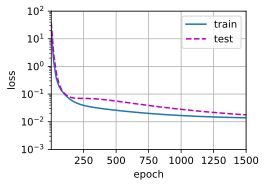

In [16]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)

接下来，将继续讨论过拟合问题和处理这些问题的⽅法，例如权重衰减和dropout。
## 小结
* ⽋拟合是指模型⽆法继续减少训练误差。过拟合是指训练误差远⼩于验证误差。
* 由于不能基于训练误差来估计泛化误差，因此简单地最⼩化训练误差并不⼀定意味着泛化误差的减⼩。机器学习模型需要注意防⽌过拟合，即防⽌泛化误差过⼤。
* 验证集可以⽤于模型选择，但不能过于随意地使⽤它。
* 应该选择⼀个复杂度适当的模型，避免使⽤数量不⾜的训练样本。
